In [1]:
import pandas as pd
import numpy as np
import math
import copy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedShuffleSplit,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

**Load the dataset and construct a feature vector for each article in the entire dataset.**

In [2]:
col_names = ["ArticleId","Text","Category"]
raw_df = pd.read_csv("train.csv", header=0, names=col_names)

In [3]:
raw_df.sample(5)
#Show 5 sample from the dataset

,ArticleId,Text,Category
246,37,gamers snap new sony psp gamers bought almost ...,tech
14,1394,viewers able shape tv imagine editing titanic ...,tech
415,909,british library gets wireless net visitors bri...,tech
294,1269,remote control rifle range debuts soon could g...,tech
156,1847,blind student hears colour blind student devel...,tech


In [4]:
duplicates = raw_df.duplicated(subset=["Text"]) # find redundant sample
num_duplicates = duplicates.sum()               # count of redundant samples
df = raw_df.drop_duplicates(subset=["Text"])    # remove redundant samples
df.reset_index(drop=True, inplace=True)         

X_train = df["Text"] #Features of training set
y_train = df["Category"] #Label of training set

vector = CountVectorizer()
BoW = vector.fit_transform(X_train)

dataset = pd.DataFrame(BoW.toarray(), columns=vector.get_feature_names_out())
dataset.insert(0, "Category", y_train, True)
#Transforming Text into Bag of Word vector, Re assemble a new training set

In [5]:
print(f"Dataset size: {raw_df.shape[0]}")
print(f"Number of duplicate articles: {num_duplicates}")
print(f"Number of articles after removing duplicates: {BoW.shape[0]}")
print(f"Number of extracted features: {BoW.shape[1]}")
print("Sample of 5 examples:")
dataset.sample(5)

Dataset size: 428
Number of duplicate articles: 26
Number of articles after removing duplicates: 402
Number of extracted features: 13518
Sample of 5 examples:


,Category,00,000,000th,001st,0051,007,0100,0130,028,...,zola,zombie,zombies,zone,zonealarm,zones,zoom,zooms,zooropa,zorro
142,entertainment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
170,entertainment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,tech,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
229,tech,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257,tech,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**The distribution of classes in the dataset**

['tech', 'entertainment']


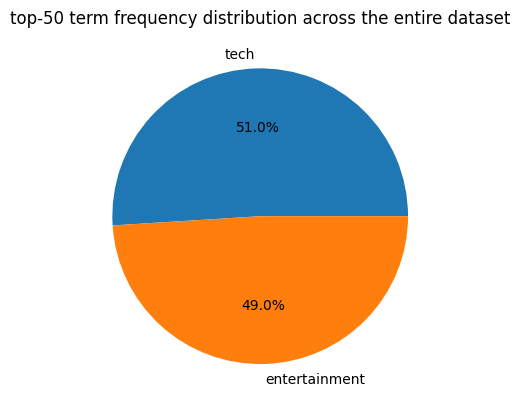

In [6]:
class_distribution_number = list(dataset['Category'].value_counts())
class_distribution_category = list(dataset['Category'].unique())
print(class_distribution_category)

plt.pie(class_distribution_number, labels=class_distribution_category, autopct='%1.1f%%')
plt.title("top-50 term frequency distribution across the entire dataset")
plt.show()

In the following code section we are combining both training and testing data before going through vectorisation process to simplify the job for our classifiers by having vectorised training and testing examples of the same shape.

(We reestablish training set and testing set again because this is from a group assignment and we don't want to alter too much to cause codes from other parts break down)

In [7]:
df = pd.read_csv("train.csv", header=0,index_col="ArticleId")
duplicates = df.duplicated(subset=["Text"])
num_duplicates = duplicates.sum()
df = df.drop_duplicates(subset=["Text"])
df_test = pd.read_csv("test.csv", header=0,index_col="ArticleId")
#Loading training data and testing data. Remove redundant entry from training data

X_train = df["Text"]
y_train = df["Category"]

X_test = df_test["Text"]
y_test = df_test["Category"]

X_combined = pd.concat([X_train, X_test])
#Combine both sets together to transform into vectors at the same time, otherwise vectors in training set may not be compatible with vector in testing set
vector = CountVectorizer()
BoW = vector.fit_transform(X_combined)

X_combined_vector = pd.DataFrame(BoW.toarray(), columns=vector.get_feature_names_out(),index=X_combined.index)

X_BoW_train = X_combined_vector.loc[df.index]
X_BoW_test = X_combined_vector.loc[df_test.index]
#Bag of Word transformation
# use X_BoW_train, y_train for training 
# use X_BoW_test, y_test for testing

print(f"X_train shape:", X_BoW_train.shape)
print(f"y_train shape:", y_train.shape)
print()
print(f"X_test shape:", X_BoW_test.shape)
print(f"y_test shape:", y_test.shape)

X_train shape: (402, 14927)
y_train shape: (402,)

X_test shape: (106, 14927)
y_test shape: (106,)



#### (a) Naive Bayes classification model 

In [8]:
classifier = MultinomialNB()
classifier.fit(X_BoW_train, y_train);

##### (i) For all the word in features

In [9]:
# get vocab from countvectorizer
feature_names = vector.get_feature_names_out()
# get labels
class_labels = classifier.classes_
# get likelihood calculated from training
class_log_probabilities = classifier.feature_log_prob_
top_20_words = {}

for i, label in enumerate(class_labels):
    top_words_indices = class_log_probabilities[i, :].argsort()[-20:][::-1]
    top_words = [feature_names[idx] for idx in top_words_indices]
    top_20_words[label] = top_words

In [10]:
print("Entertainment top 20 words: ", top_20_words['entertainment'])
print("Tech top 20 words: ", top_20_words['tech'])

Entertainment top 20 words:  ['said', 'film', 'best', 'year', 'also', 'music', 'new', 'us', 'one', 'show', 'first', 'awards', 'tv', 'actor', 'last', 'uk', 'mr', 'number', 'star', 'award']
Tech top 20 words:  ['said', 'people', 'new', 'mr', 'one', 'mobile', 'also', 'could', 'would', 'technology', 'use', 'net', 'users', 'games', 'us', 'software', 'music', 'many', 'phone', 'year']


##### (ii) with condition

In [11]:
top_20_words = {'entertainment': [], 'tech': []}

for index, word in enumerate(feature_names):
    entertainment = class_log_probabilities[0, index]
    tech = class_log_probabilities[1, index]
    ratio = entertainment - tech
    ratio2 = tech - entertainment
    # check conditional probability
    if ratio > ratio2:
        top_20_words[class_labels[0]].append((word, ratio))
    else:
        top_20_words[class_labels[1]].append((word, ratio2))
  
# sort the top 20 words for each label in high to low order
for label in class_labels:
    top_20_words[label].sort(key=lambda x: x[1], reverse=True)
    top_20_words[label] = [word for word, _ in top_20_words[label][:20]]

In [12]:
print("Entertainment top 20 words: ", top_20_words['entertainment'])
print("Tech top 20 words: ", top_20_words['tech'])

Entertainment top 20 words:  ['actress', 'singer', 'oscar', 'stars', 'aviator', 'band', 'nominated', 'festival', 'rock', 'album', 'charles', 'nominations', 'foxx', 'oscars', 'starring', 'chart', 'jamie', 'swank', 'ballet', 'actor']
Tech top 20 words:  ['users', 'software', 'microsoft', 'mobile', 'broadband', 'net', 'virus', 'pc', 'firms', 'gadget', 'machines', 'spam', 'windows', 'phones', 'gadgets', 'pcs', 'mobiles', 'nintendo', 'technology', 'bt']


##### Which list of words describe the two classes better? Briefly explain your reasoning.

The list in (ii) describes the classes better. Given the conditional probabilities to calculate, it maximises the probability for the word that describes each classes the most. For every word in features, if the probability of each word occuring in one class is greater than the other, than it can be indication of this word being more describtive in certain class. By sorting the probability of such word in order (ii) is produced. Hence, the second list of words are more descriptive than the (i).

#### (b) K Nearest Neighbour classification model 

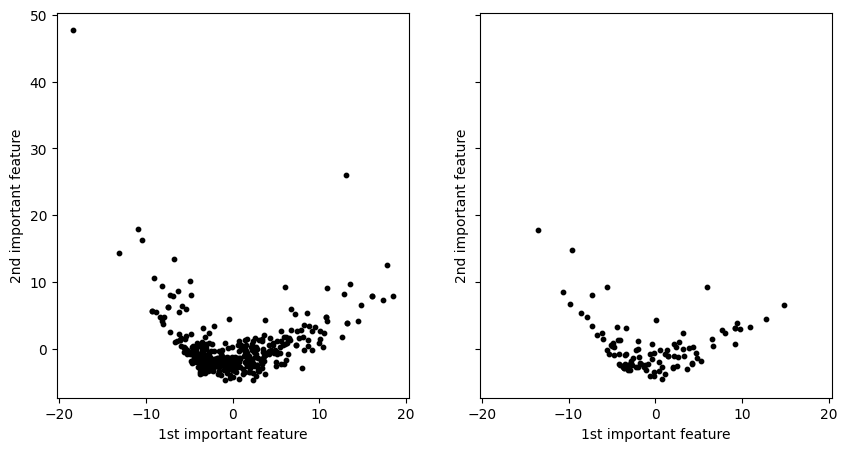

In [13]:
pca = PCA(random_state=374564)
X_Domain_PCA = pca.fit_transform(X_combined_vector)
X_BoW_PCA=pd.DataFrame([X_Domain_PCA[:, 0], X_Domain_PCA[:, 1]],index=['1st important dimension','2nd important dimension'],columns=X_combined.index).T
#PCA transformation on Bag of Words vector

X_BoW_PCA_Train=X_BoW_PCA.loc[df.index]
X_BoW_PCA_Test=X_BoW_PCA.loc[df_test.index]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5), sharex=True, sharey=True)
ax1.scatter(X_BoW_PCA_Train["1st important dimension"], X_BoW_PCA_Train['2nd important dimension'], c='k', s=10)
ax2.scatter(X_BoW_PCA_Test["1st important dimension"], X_BoW_PCA_Test['2nd important dimension'], c='k', s=10)
ax1.set_xlabel('1st important feature')
ax1.set_ylabel('2nd important feature')
ax2.set_xlabel('1st important feature')
ax2.set_ylabel('2nd important feature')
plt.show()
plt.close(fig)

Since the BoW vector has about 11000 dimensions, with most of its value filled with 0 or occasionally 1 or 2, it's impossible to find 2 features that best represent the vector. So I apply PCA to transoform the vector into 2 most representative features. The left scatter graph represent transformed training data points and the right scatter graph represent transformed testing data points. 

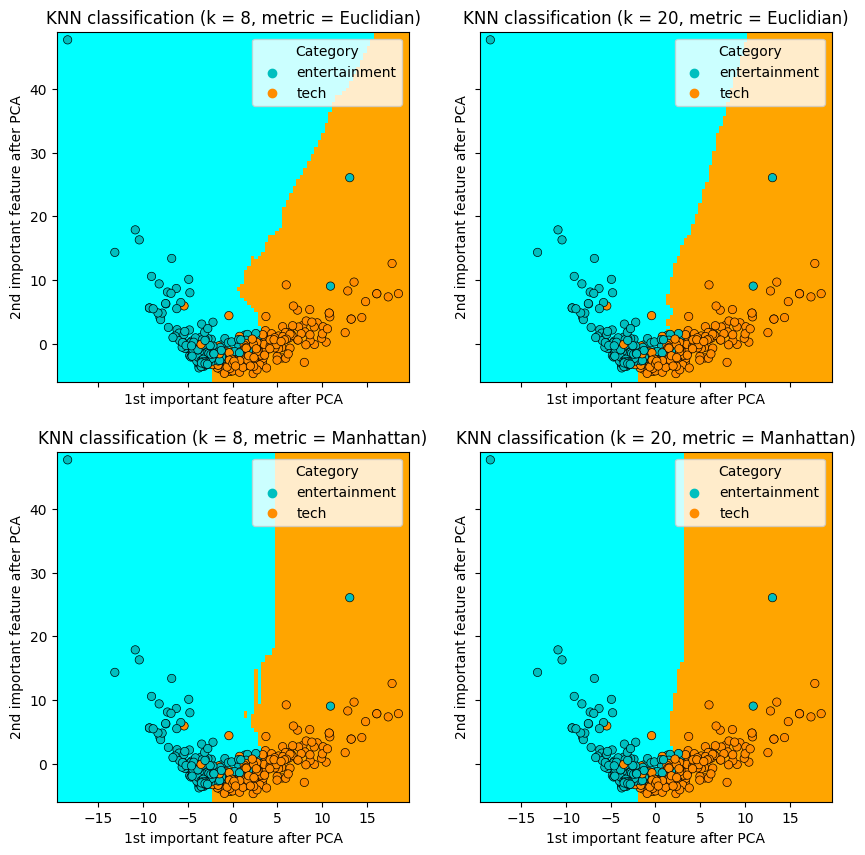

In [14]:
cmap_light = ListedColormap(["cyan","orange"])
cmap_bold = ["c","darkorange"]
fig, axes=plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
list_of_ax=axes.tolist()
list_of_ax=list_of_ax[0]+list_of_ax[1]
ax_index=0

for k,m in [[8,"l2"],[20,"l2"],[8,"l1"],[20,"l1"]]:
    knn = KNeighborsClassifier(k,metric=m)
    knn.fit(X_BoW_PCA_Train, y_train)

    ax=list_of_ax[ax_index]
    DecisionBoundaryDisplay.from_estimator(
        knn,
        X_BoW_PCA_Train,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel='1st important feature after PCA',
        ylabel='2nd important feature after PCA',
        shading="auto",
    )

    sns.scatterplot(
        x=X_BoW_PCA_Train["1st important dimension"],
        y=X_BoW_PCA_Train['2nd important dimension'],
        hue=y_train,
        hue_order=["entertainment","tech"],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
        ax=ax
    )
    metric_desc="Euclidian" if m=="l2" else "Manhattan"
    ax.set_title(
        f"KNN classification (k = {k}, metric = {metric_desc})"
    )
    ax_index+=1

plt.show()

The KNN model I trained is on the PCA training data points with value of k being 8 and the distance metric being Euclidian (L2 distance). The top left graph represent the decision boundary of the KNN model

The other 3 graph illustrates the effect of change in hyperparameter to the decision boundary. As the value of k increase, the decision boundary will be less subjected to outliner in the data, the shape between two clusters of data will also be smoother. When the distance metric switch from Euclidian to Mahanttan (L1 distance), the shape of the decsion boudary appeared to be more discrete.

#### (c) Support Vector Machine Classifier

In [15]:
vector = CountVectorizer()
BoW_count_train = vector.fit_transform(X_train)


enc = OneHotEncoder()
enc.fit(BoW_count_train.toarray())
X_convert = enc.transform(BoW_count_train.toarray()).toarray()

label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y_train)

Creating features from the words and then encoding X such that it is able to be processed later on for the graph as well as to reduce complexity

Convert categorical data to numerical

In [16]:
SVM_X_train, SVM_X_test, SVM_y_train, SVM_y_test = train_test_split(X_convert, encoded_y, test_size=0.3,random_state=109)

##### (i) Soft Margin SVM classification model 

In [17]:
classifier = svm.SVC(kernel='linear', C=0.1)
classifier.fit(SVM_X_train, SVM_y_train)
print("The accuracy score of the classifier: ", classifier.score(SVM_X_test, SVM_y_test))

The accuracy score of the classifier:  0.9504132231404959


In [18]:
scaler = StandardScaler()

scaler.fit(SVM_X_test)

X_scaled = scaler.transform(SVM_X_test)

pca = PCA(n_components=2, random_state=1)
pca.fit(SVM_X_test)

X_pca = pca.transform(SVM_X_test)
#PCA transform data for better performing. 

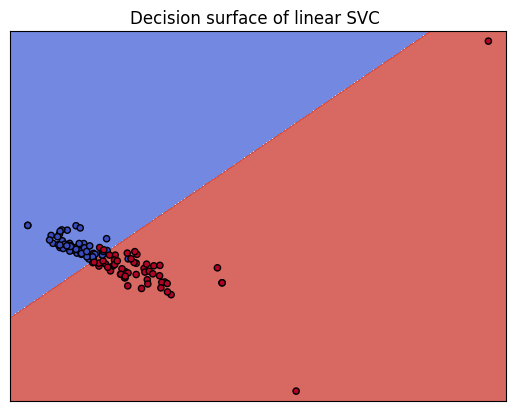

In [19]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = svm.SVC(kernel="linear", C=0.1)
clf = model.fit(X_pca, SVM_y_test)

fig, ax = plt.subplots()# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.

X0, X1 = X_pca[:, 0], X_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=SVM_y_test, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

##### (ii) Hard Margin RBF kernel SVM classification model 

In [20]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_pca, SVM_y_test)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.96


In [21]:
hardclassifier = svm.SVC(kernel='rbf', C=0.1, gamma=0.1)
hardclassifier.fit(SVM_X_train, SVM_y_train)
print(classifier.score(SVM_X_test, SVM_y_test))

0.9504132231404959


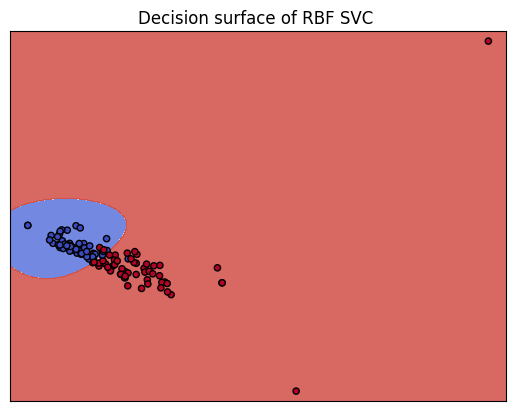

In [22]:
hardmodel = svm.SVC(kernel="rbf", C=0.1, gamma=0.1)
hardclf = hardmodel.fit(X_pca, SVM_y_test)

fig, ax = plt.subplots()# title for the plots
title = ('Decision surface of RBF SVC ')
# Set-up grid for plotting.

X0, X1 = X_pca[:, 0], X_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, hardclf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=SVM_y_test, cmap=plt.cm.coolwarm, s=20, edgecolors="k")

ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()
#Hard Kenerlized SVM model

##### Explain the impact of penalty 𝐶 on the soft-margin decision boundaries, as well as the kernel hyperparameter on the hard-margin decision boundaries.

The impact of penalty C has little effect when looking at the data as shown in the surfaces above. As the data is for the most part a strong linear relationship with a gap between groups red and blue, as such this gap between the two has efficiently been used to maximise correct classification, with very little outliers for each group (only blue group has outliers which are classified incorrectly).

As shown above, a small gamma of 0.1 is used. As gamma is the inverse of the radius of influence, a lower gamma results in a higher kernel width. This is to help prevent overfitting whilst also maintaining a high accuracy, this however had little affect as well with this data due to the strong relation between instances of each given classification. This data may be skewed slightly however due to the reduction of complexity with each word being used as a feature, as in this reduction of complexity there also may be a loss in information as features that are not as crucial have the same weighting as those with more influence. Iveral however with an accuracy of 97% this is very trivial.

#### (d) Neural Network

In [23]:
HIDDEN_UNITS = [5,20,40]
OPTIMISATION_EPOCHS = 100
LEARNING_RATE = 0.01
RANDOM_SEED = 361

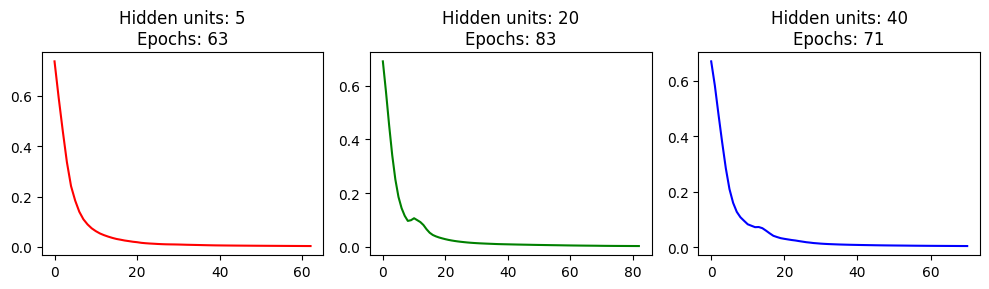

In [24]:
plt.figure(figsize=(10, 3)) 
colors = ['red', 'green', 'blue']

for (i, u) in enumerate(HIDDEN_UNITS):
    nn = MLPClassifier(
        hidden_layer_sizes=(u,),
        solver="sgd",
        random_state=RANDOM_SEED,
        max_iter=OPTIMISATION_EPOCHS,
        learning_rate_init=LEARNING_RATE,
        early_stopping=False,
    )
    nn.fit(X_BoW_train, y_train)

    plt.subplot(1, 3, i+1)
    plt.plot(nn.loss_curve_, color=colors[i])
    plt.title(f'Hidden units: {u}\nEpochs: {len(nn.loss_curve_)}')

plt.tight_layout()
plt.show()

The number of hidden units doesn't seem to have a very pronounced effect on the loss curve. It exhibits similar behavior, showing a relatively steep decline initially and then slowing down substantially, with only minor observed differences.

However, the number of hidden units does seem to affect the convergence of the model, but the relationship is not linear. In this case, the model with 20 hidden units took the longest to converge, requiring 83 epochs.

**Use 5-fold cross-validation to assess model performance. Investigate the impact of key hyperparameters of your choices for each classifier using a testing dataset**

### Part A Naive Bayes Classisifier

In [25]:
# hyper-parameter values for cv
param_grid = {'alpha': [0, 0.01, 0.1, 0.25, 0.5, 1.0, 2.0]} 

# force_alpha is set to true to observe the performance when alpha = 0, which force to run under no smoothing method
classifier = MultinomialNB(force_alpha=True)

# perform grid search with 5 fold cross validation and score matrix of f1
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_BoW_train, y_train)

print(grid_search.cv_results_['mean_test_score']) # it prints the average f1 score of 5 fold cv
print(grid_search.best_params_)                   # prints out the parameter value with the highest f1-score


c:\Users\15783\source\repos\Fairness-Metrics-Research\venv\Lib\site-packages\sklearn\naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\15783\source\repos\Fairness-Metrics-Research\venv\Lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\15783\source\repos\Fairness-Metrics-Research\venv\Lib\site-packages\sklearn\naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\15783\source\repos\Fairness-Metrics-Research\venv\Lib\site-packages\sklearn\utils\extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
c:\Users\15783\source\repos\Fairness-Metrics-Research\venv\Lib\site-packages\sklearn\naive_bayes.py:903: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
c:\Users\15783\sou

[0.33773201 0.98254963 0.98505002 0.98253552 0.98003513 0.98003513
 0.98012117]
{'alpha': 0.1}


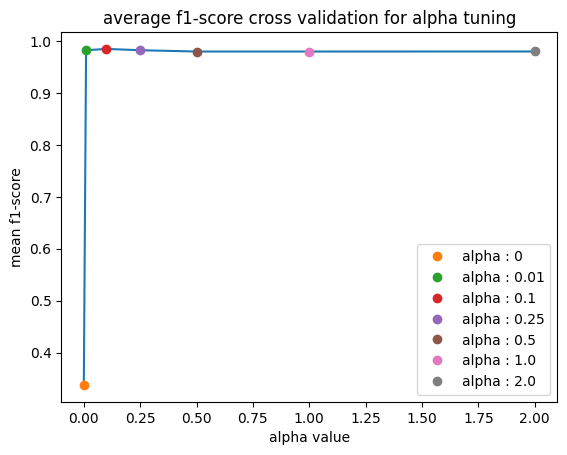

In [26]:
plt.plot(param_grid['alpha'], grid_search.cv_results_['mean_test_score']) # the line in the graph below shows how f1-score changes from difference alpha value

# for intuitive understanding plot the point correspond to each alpha value and its f1-score
for i in range(len(param_grid['alpha'])):
  plt.plot(param_grid['alpha'][i], grid_search.cv_results_['mean_test_score'][i], label="alpha : "+str(param_grid['alpha'][i]), marker='o', linestyle='None')

# plot graph
plt.title("average f1-score cross validation for alpha tuning")
plt.xlabel("alpha value")
plt.ylabel("mean f1-score")
plt.legend()
plt.show()

The only hyper-parameter in multinomial naive bayes is the alpha parameter. The alpha is an additive smoothing parameter to avoid zero division. In the experiment I have carried out grid search with 5-fold cross validation to tune these hyper-parameter. 

The tested parameter values varies from 0 to 2. As shown above, there is not much difference between value 0.01 to 2 but 0 has very low f1-score. This can be due to removing smoothing in the classifier, hence producing zero divisions. Increasing the alpha value greater to greather than 0 will regularize the count. 

The experiment concludes that, for given dataset the alpha value with 0.1 has the highest f1-score, but the difference from other alpha values are negligible excepth for alpha = 0 (which is = no smoothing).

### Part B KNN Neearest Neighbour Classifier

The hyperparameter of KNN includes value k, distance metric (Euclidian or Mahanttan) and voting weight (Uniform or Distance)

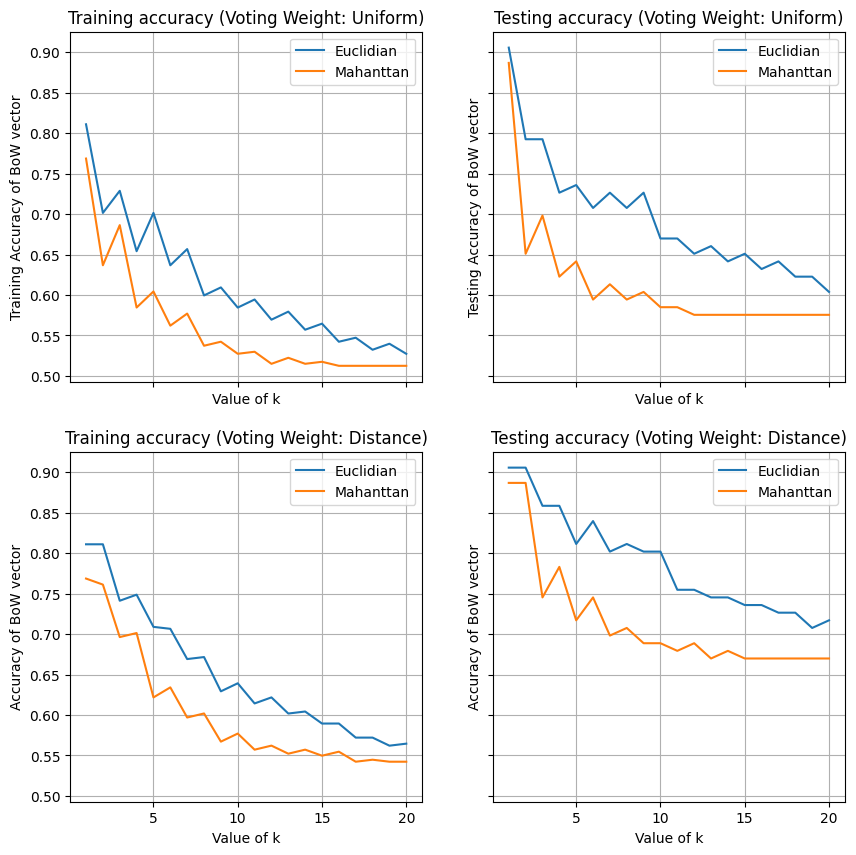

In [27]:
k_range = range(1, 21)
Train_scores_L2, Train_scores_L1,Test_scores_L2, Test_scores_L1 = [], [], [], []
Train_scores_distance_L2, Train_scores_distance_L1,Test_scores_distance_L2, Test_scores_distance_L1 = [], [], [], []

for k in k_range:
    knn_l2 = KNeighborsClassifier(n_neighbors=k, metric='l2')
    accuracy_l2=cross_val_score(estimator=knn_l2,X=X_BoW_train,y=y_train,cv=5)
    Train_scores_L2.append(sum(accuracy_l2)/5)
    knn_l2.fit(X_BoW_train,y_train)
    y_pred_l2=knn_l2.predict(X_BoW_test)
    Test_scores_L2.append(metrics.accuracy_score(y_test,y_pred_l2))

    knn_l1 = KNeighborsClassifier(n_neighbors=k, metric='l1')
    accuracy_l1=cross_val_score(estimator=knn_l1,X=X_BoW_train,y=y_train,cv=5)
    Train_scores_L1.append(sum(accuracy_l1)/5)
    knn_l1.fit(X_BoW_train,y_train)
    y_pred_l1=knn_l1.predict(X_BoW_test)
    Test_scores_L1.append(metrics.accuracy_score(y_test,y_pred_l1))

    knn_distance_l2 = KNeighborsClassifier(n_neighbors=k, metric='l2',weights="distance")
    accuracy_distance_l2=cross_val_score(estimator=knn_distance_l2,X=X_BoW_train,y=y_train,cv=5)
    Train_scores_distance_L2.append(sum(accuracy_distance_l2)/5)
    knn_distance_l2.fit(X_BoW_train,y_train)
    y_pred_distance_l2=knn_distance_l2.predict(X_BoW_test)
    Test_scores_distance_L2.append(metrics.accuracy_score(y_test,y_pred_distance_l2))

    knn_distance_l1 = KNeighborsClassifier(n_neighbors=k, metric='l1',weights="distance")
    accuracy_distance_l1=cross_val_score(estimator=knn_distance_l1,X=X_BoW_train,y=y_train,cv=5)
    Train_scores_distance_L1.append(sum(accuracy_distance_l1)/5)
    knn_distance_l1.fit(X_BoW_train,y_train)
    y_pred_distance_l1=knn_distance_l1.predict(X_BoW_test)
    Test_scores_distance_L1.append(metrics.accuracy_score(y_test,y_pred_distance_l1))
    

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2,figsize=(10,10), sharex=True, sharey=True)

ax1.set_title("Training accuracy (Voting Weight: Uniform)")
ax1.plot(k_range, Train_scores_L2,label="Euclidian")
ax1.plot(k_range, Train_scores_L1,label="Mahanttan")
ax1.grid()
ax1.legend()
ax1.set_xlabel('Value of k')
ax1.set_ylabel('Training Accuracy of BoW vector')

ax2.set_title("Testing accuracy (Voting Weight: Uniform)")
ax2.plot(k_range, Test_scores_L2,label="Euclidian")
ax2.plot(k_range, Test_scores_L1,label="Mahanttan")
ax2.grid()
ax2.legend()
ax2.set_xlabel('Value of k')
ax2.set_ylabel('Testing Accuracy of BoW vector')

ax3.set_title("Training accuracy (Voting Weight: Distance)")
ax3.plot(k_range, Train_scores_distance_L2,label="Euclidian")
ax3.plot(k_range, Train_scores_distance_L1,label="Mahanttan")
ax3.grid()
ax3.legend()
ax3.set_xlabel('Value of k')
ax3.set_ylabel('Accuracy of BoW vector')

ax4.set_title("Testing accuracy (Voting Weight: Distance)")
ax4.plot(k_range, Test_scores_distance_L2,label="Euclidian")
ax4.plot(k_range, Test_scores_distance_L1,label="Mahanttan")
ax4.grid()
ax4.legend()
ax4.set_xlabel('Value of k')
ax4.set_ylabel('Accuracy of BoW vector')

plt.show()
plt.close(fig)

In [28]:
max_acc_l2=max(Test_scores_L2)
max_k_l2=Test_scores_L2.index(max_acc_l2)
print(f"The Maximun testing accuracy with BoW vector, Euclidian metric and Uniform voting weight is {max_acc_l2}. It has k value of {max_k_l2+1} and its training accuracy is {Train_scores_L2[max_k_l2]}")
max_acc_l1=max(Test_scores_L1)
max_k_l1=Test_scores_L1.index(max_acc_l1)
print(f"The Maximun testing accuracy with BoW vector, Mahanttan metric and Uniform voting weight is {max_acc_l1}. It has k value of {max_k_l1+1} and its training accuracy is {Train_scores_L1[max_k_l1]}")
max_acc_distance_l2=max(Test_scores_distance_L2)
max_k_distance_l2=Test_scores_distance_L2.index(max_acc_distance_l2)
print(f"The Maximun testing accuracy with BoW vector, Euclidian metric and Distance voting weight is {max_acc_distance_l2}. It has k value of {max_k_distance_l2+1} and its training accuracy is {Train_scores_distance_L2[max_k_distance_l2]}")
max_acc_distance_l1=max(Test_scores_distance_L1)
max_k_distance_l1=Test_scores_distance_L1.index(max_acc_distance_l1)
print(f"The Maximun testing accuracy with BoW vector, Manhattan metric and Distance voting weight is {max_acc_distance_l1}. It has k value of {max_k_distance_l1+1} and its training accuracy is {Train_scores_distance_L1[max_k_distance_l1]}")

The Maximun testing accuracy with BoW vector, Euclidian metric and Uniform voting weight is 0.9056603773584906. It has k value of 1 and its training accuracy is 0.8109259259259259
The Maximun testing accuracy with BoW vector, Mahanttan metric and Uniform voting weight is 0.8867924528301887. It has k value of 1 and its training accuracy is 0.7685802469135803
The Maximun testing accuracy with BoW vector, Euclidian metric and Distance voting weight is 0.9056603773584906. It has k value of 1 and its training accuracy is 0.8109259259259259
The Maximun testing accuracy with BoW vector, Manhattan metric and Distance voting weight is 0.8867924528301887. It has k value of 1 and its training accuracy is 0.7685802469135803


The comparison of 5 fold cross validation and testing accuracy of KNN model training on BoW vector. It compare the perfromance of k values range from 1 to 20, and between the performance of Euclidian and Mahanttan distance metric

With BoW Vector, as k value increase, both the training accuracy and the testing accuracy decrease. The Euclidian perfomr much better than the Mahanttan with all values of k.

Changing voting weight from Uniform to Distance only slow down the rate of decreasing accuracy with subject to the increasing value of k 

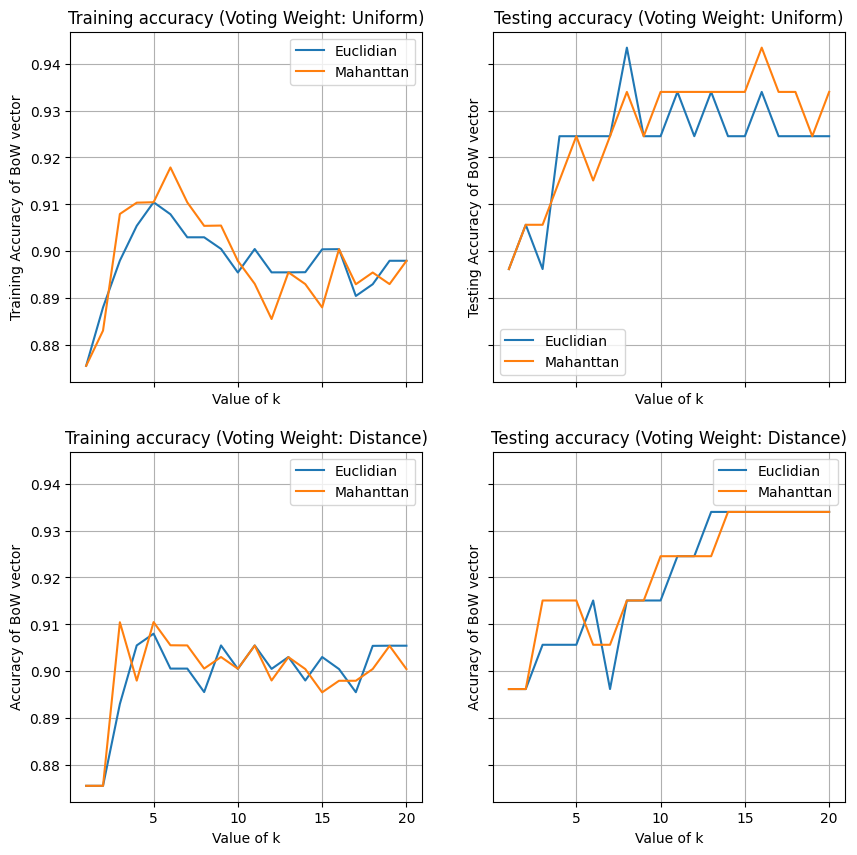

In [29]:
k_range = range(1, 21)
Train_scores_L2, Train_scores_L1,Test_scores_L2, Test_scores_L1 = [], [], [], []
Train_scores_distance_L2, Train_scores_distance_L1,Test_scores_distance_L2, Test_scores_distance_L1 = [], [], [], []

for k in k_range:
    knn_l2 = KNeighborsClassifier(n_neighbors=k, metric='l2')
    accuracy_l2=cross_val_score(estimator=knn_l2,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Train_scores_L2.append(sum(accuracy_l2)/5)
    knn_l2.fit(X_BoW_PCA_Train,y_train)
    y_pred_l2=knn_l2.predict(X_BoW_PCA_Test)
    Test_scores_L2.append(metrics.accuracy_score(y_test,y_pred_l2))

    knn_l1 = KNeighborsClassifier(n_neighbors=k, metric='l1')
    accuracy_l1=cross_val_score(estimator=knn_l1,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Train_scores_L1.append(sum(accuracy_l1)/5)
    knn_l1.fit(X_BoW_PCA_Train,y_train)
    y_pred_l1=knn_l1.predict(X_BoW_PCA_Test)
    Test_scores_L1.append(metrics.accuracy_score(y_test,y_pred_l1))

    knn_distance_l2 = KNeighborsClassifier(n_neighbors=k, metric='l2',weights="distance")
    accuracy_distance_l2=cross_val_score(estimator=knn_distance_l2,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Train_scores_distance_L2.append(sum(accuracy_distance_l2)/5)
    knn_distance_l2.fit(X_BoW_PCA_Train,y_train)
    y_pred_distance_l2=knn_distance_l2.predict(X_BoW_PCA_Test)
    Test_scores_distance_L2.append(metrics.accuracy_score(y_test,y_pred_distance_l2))

    knn_distance_l1 = KNeighborsClassifier(n_neighbors=k, metric='l1',weights="distance")
    accuracy_distance_l1=cross_val_score(estimator=knn_distance_l1,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Train_scores_distance_L1.append(sum(accuracy_distance_l1)/5)
    knn_distance_l1.fit(X_BoW_PCA_Train,y_train)
    y_pred_distance_l1=knn_distance_l1.predict(X_BoW_PCA_Test)
    Test_scores_distance_L1.append(metrics.accuracy_score(y_test,y_pred_distance_l1))
    

fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2,figsize=(10,10), sharex=True, sharey=True)

ax1.set_title("Training accuracy (Voting Weight: Uniform)")
ax1.plot(k_range, Train_scores_L2,label="Euclidian")
ax1.plot(k_range, Train_scores_L1,label="Mahanttan")
ax1.grid()
ax1.legend()
ax1.set_xlabel('Value of k')
ax1.set_ylabel('Training Accuracy of BoW vector')

ax2.set_title("Testing accuracy (Voting Weight: Uniform)")
ax2.plot(k_range, Test_scores_L2,label="Euclidian")
ax2.plot(k_range, Test_scores_L1,label="Mahanttan")
ax2.grid()
ax2.legend()
ax2.set_xlabel('Value of k')
ax2.set_ylabel('Testing Accuracy of BoW vector')

ax3.set_title("Training accuracy (Voting Weight: Distance)")
ax3.plot(k_range, Train_scores_distance_L2,label="Euclidian")
ax3.plot(k_range, Train_scores_distance_L1,label="Mahanttan")
ax3.grid()
ax3.legend()
ax3.set_xlabel('Value of k')
ax3.set_ylabel('Accuracy of BoW vector')

ax4.set_title("Testing accuracy (Voting Weight: Distance)")
ax4.plot(k_range, Test_scores_distance_L2,label="Euclidian")
ax4.plot(k_range, Test_scores_distance_L1,label="Mahanttan")
ax4.grid()
ax4.legend()
ax4.set_xlabel('Value of k')
ax4.set_ylabel('Accuracy of BoW vector')

plt.show()
plt.close(fig)

In [30]:
max_acc_l2=max(Test_scores_L2)
max_k_l2=Test_scores_L2.index(max_acc_l2)
print(f"The Maximun testing accuracy with BOW after PCA, Euclidian metric and Uniform voting weight is {max_acc_l2}. It has k value of {max_k_l2+1} and its training accuracy is {Train_scores_L2[max_k_l2]}")
max_acc_l1=max(Test_scores_L1)
max_k_l1=Test_scores_L1.index(max_acc_l1)
print(f"The Maximun testing accuracy with BOW after PCA, Mahanttan metric and Uniform voting weight is {max_acc_l1}. It has k value of {max_k_l1+1} and its training accuracy is {Train_scores_L1[max_k_l1]}")
max_acc_distance_l2=max(Test_scores_distance_L2)
max_k_distance_l2=Test_scores_distance_L2.index(max_acc_distance_l2)
print(f"The Maximun testing accuracy with BOW after PCA, Euclidian metric and Distance voting weight is {max_acc_distance_l2}. It has k value of {max_k_distance_l2+1} and its training accuracy is {Train_scores_distance_L2[max_k_distance_l2]}")
max_acc_distance_l1=max(Test_scores_distance_L1)
max_k_distance_l1=Test_scores_distance_L1.index(max_acc_distance_l1)
print(f"The Maximun testing accuracy with BOW after PCA, Manhattan metric and Distance voting weight is {max_acc_distance_l1}. It has k value of {max_k_distance_l1+1} and its training accuracy is {Train_scores_distance_L1[max_k_distance_l1]}")

The Maximun testing accuracy with BOW after PCA, Euclidian metric and Uniform voting weight is 0.9433962264150944. It has k value of 8 and its training accuracy is 0.9029938271604937
The Maximun testing accuracy with BOW after PCA, Mahanttan metric and Uniform voting weight is 0.9433962264150944. It has k value of 16 and its training accuracy is 0.900462962962963
The Maximun testing accuracy with BOW after PCA, Euclidian metric and Distance voting weight is 0.9339622641509434. It has k value of 13 and its training accuracy is 0.9030555555555555
The Maximun testing accuracy with BOW after PCA, Manhattan metric and Distance voting weight is 0.9339622641509434. It has k value of 14 and its training accuracy is 0.9004938271604939


The comparison of 5 fold cross validation and testing accuracy of KNN model training on PCA vector. It compare the perfromance of k values range from 1 to 20, and between the performance of Euclidian and Mahanttan distance metric

With PCA Vector, low value k like 1 or 2 yield the smallest training and testing accuracy. When the k value increase, the accuracy fluncutate with traning accuracy varied between 0.89 and 0.91 and testing accuracy varied between 0.92 and 0.94 with some outliner (0.90 and 0.93 if the voting weight is Distance). Due to fluncuation, there is no distince difference on training accuracy between distance metrics. When value of k is less than 10, the testing accuracy with Euclidian distance metrics is smaller than or equalto the training accuracy with Mahanttan distance metrics. Otherwise, the testing accuracy with Euclidian distance metrics is greater than or equalto the training accuracy with Mahanttan distance metrics.  

Changing voting weight from Uniform to Distance make the training and the testing accuracy flunctuate less across all values of k. On average traning accuracy with Distance voting weight is greater than training accuracy with Uniform voting weight. And on average testing accuracy with Distance voting weight is smaller than testing accuracy with Uniform voting weight.

### Part C Support Vector Machine SVM

The hyperparameter includes C the penality coeficient, Kenerl methods (linear, Polynomial, Radial Basis Function). In case of Polynomial, there are also hyperparameter of its degree. And in case of Radial Basis Function, there is hyperparameter of its gamma value.

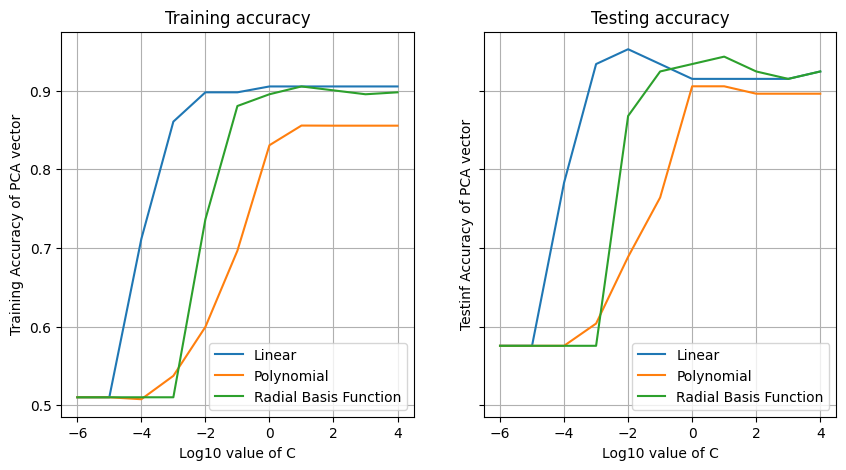

In [31]:
C_range = np.logspace(-6, 4, 11)
C_log_range=[math.log10(c) for c in C_range]
Model_Score={}

Model_Score["PCA,Linear,Train"]=[]
Model_Score["PCA,Linear,Test"]=[]

Model_Score["PCA,Polynomial,Train"]=[]
Model_Score["PCA,Polynomial,Test"]=[]

Model_Score["PCA,RBF,Train"]=[]
Model_Score["PCA,RBF,Test"]=[]

for c in C_range :
    
    svm_model=svm.SVC(C=c,kernel="linear")

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["PCA,Linear,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["PCA,Linear,Test"].append(metrics.accuracy_score(y_test,y_pred))

    svm_model=svm.SVC(C=c,kernel="poly")

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["PCA,Polynomial,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["PCA,Polynomial,Test"].append(metrics.accuracy_score(y_test,y_pred))

    svm_model=svm.SVC(C=c,kernel="rbf")

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["PCA,RBF,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["PCA,RBF,Test"].append(metrics.accuracy_score(y_test,y_pred))
    

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5), sharex=True, sharey=True)

ax1.set_title("Training accuracy")
ax1.plot(C_log_range, Model_Score["PCA,Linear,Train"],label="Linear")
ax1.plot(C_log_range, Model_Score["PCA,Polynomial,Train"],label="Polynomial")
ax1.plot(C_log_range, Model_Score["PCA,RBF,Train"],label="Radial Basis Function")
ax1.grid()
ax1.legend()
ax1.set_xlabel('Log10 value of C')
ax1.set_ylabel('Training Accuracy of PCA vector')

ax2.set_title("Testing accuracy")
ax2.plot(C_log_range, Model_Score["PCA,Linear,Test"],label="Linear")
ax2.plot(C_log_range, Model_Score["PCA,Polynomial,Test"],label="Polynomial")
ax2.plot(C_log_range, Model_Score["PCA,RBF,Test"],label="Radial Basis Function")
ax2.grid()
ax2.legend()
ax2.set_xlabel('Log10 value of C')
ax2.set_ylabel('Testinf Accuracy of PCA vector')

plt.show()
plt.close(fig)

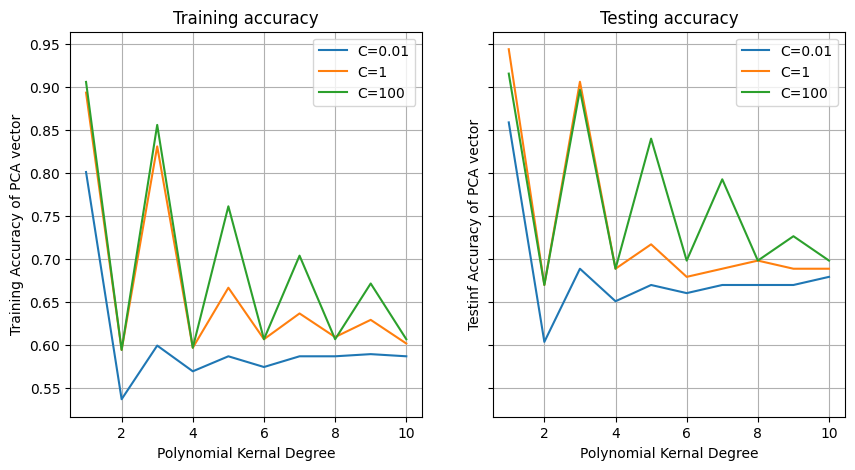

In [32]:
degree_range=range(1,11)

Model_Score={}

Model_Score["0.01,Train"]=[]
Model_Score["0.01,Test"]=[]

Model_Score["1,Train"]=[]
Model_Score["1,Test"]=[]

Model_Score["100,Train"]=[]
Model_Score["100,Test"]=[]

for d in degree_range :
    
    svm_model=svm.SVC(C=0.01,kernel="poly",degree=d)

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["0.01,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["0.01,Test"].append(metrics.accuracy_score(y_test,y_pred))

    svm_model=svm.SVC(C=1,kernel="poly",degree=d)

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["1,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["1,Test"].append(metrics.accuracy_score(y_test,y_pred))

    svm_model=svm.SVC(C=100,kernel="poly",degree=d)

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["100,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["100,Test"].append(metrics.accuracy_score(y_test,y_pred))
    

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5), sharex=True, sharey=True)

ax1.set_title("Training accuracy")
ax1.plot(degree_range, Model_Score["0.01,Train"],label="C=0.01")
ax1.plot(degree_range, Model_Score["1,Train"],label="C=1")
ax1.plot(degree_range, Model_Score["100,Train"],label="C=100")
ax1.grid()
ax1.legend()
ax1.set_xlabel('Polynomial Kernal Degree')
ax1.set_ylabel('Training Accuracy of PCA vector')

ax2.set_title("Testing accuracy")
ax2.plot(degree_range, Model_Score["0.01,Test"],label="C=0.01")
ax2.plot(degree_range, Model_Score["1,Test"],label="C=1")
ax2.plot(degree_range, Model_Score["100,Test"],label="C=100")
ax2.grid()
ax2.legend()
ax2.set_xlabel('Polynomial Kernal Degree')
ax2.set_ylabel('Testinf Accuracy of PCA vector')

plt.show()
plt.close(fig)

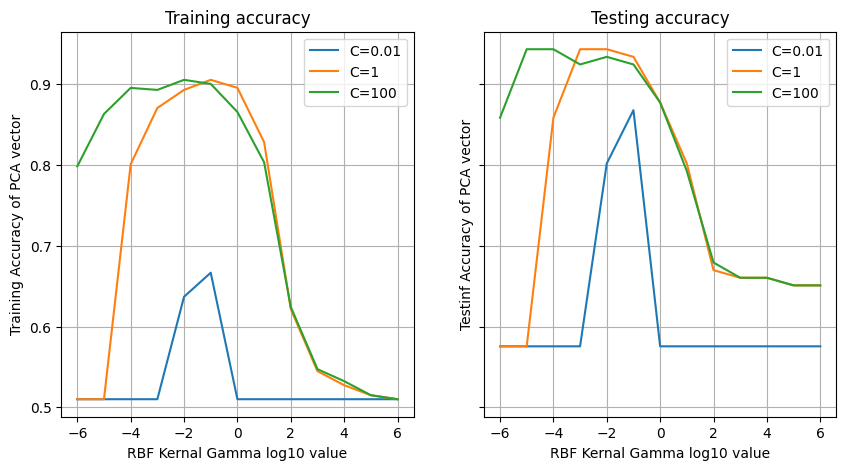

In [33]:
gamma_range = np.logspace(-6, 6, 13)
gamma_log_range=[math.log10(g) for g in gamma_range]

Model_Score={}

Model_Score["0.01,Train"]=[]
Model_Score["0.01,Test"]=[]

Model_Score["1,Train"]=[]
Model_Score["1,Test"]=[]

Model_Score["100,Train"]=[]
Model_Score["100,Test"]=[]

for g in gamma_range :
    
    svm_model=svm.SVC(C=0.01,kernel="rbf",gamma=g)

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["0.01,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["0.01,Test"].append(metrics.accuracy_score(y_test,y_pred))

    svm_model=svm.SVC(C=1,kernel="rbf",gamma=g)

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["1,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["1,Test"].append(metrics.accuracy_score(y_test,y_pred))

    svm_model=svm.SVC(C=100,kernel="rbf",gamma=g)

    accuracy=cross_val_score(estimator=svm_model,X=X_BoW_PCA_Train,y=y_train,cv=5)
    Model_Score["100,Train"].append(sum(accuracy)/5)
    svm_model.fit(X_BoW_PCA_Train,y_train)
    y_pred=svm_model.predict(X_BoW_PCA_Test)
    Model_Score["100,Test"].append(metrics.accuracy_score(y_test,y_pred))
    

fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(10,5), sharex=True, sharey=True)

ax1.set_title("Training accuracy")
ax1.plot(gamma_log_range, Model_Score["0.01,Train"],label="C=0.01")
ax1.plot(gamma_log_range, Model_Score["1,Train"],label="C=1")
ax1.plot(gamma_log_range, Model_Score["100,Train"],label="C=100")
ax1.grid()
ax1.legend()
ax1.set_xlabel('RBF Kernal Gamma log10 value')
ax1.set_ylabel('Training Accuracy of PCA vector')

ax2.set_title("Testing accuracy")
ax2.plot(gamma_log_range, Model_Score["0.01,Test"],label="C=0.01")
ax2.plot(gamma_log_range, Model_Score["1,Test"],label="C=1")
ax2.plot(gamma_log_range, Model_Score["100,Test"],label="C=100")
ax2.grid()
ax2.legend()
ax2.set_xlabel('RBF Kernal Gamma log10 value')
ax2.set_ylabel('Testinf Accuracy of PCA vector')

plt.show()
plt.close(fig)

The comparison of 5 fold cross validation and testing accuracy of SVM model training on PCA vector. It compare the perfromance of gamma for Radial Basis Function  range from $10^-6$ to $10^6$, and between C value of 0.01, 1 and 100

As the gamma value increase, the training and testing accuracy follows a parabola pattern. The shape of the parabola differ with different value of C. For C=0.01, The range of the parabola is between 0.001 to 1 and the vertext of parabola is around 0.67 for training accuracy and 0.85 for testing accuracy. For C=0.01, The range of the parabola is between $10^-5$ to 100 and the vertext of parabola is around 0.91 for training accuracy and 0.96 for testing accuracy. For C=0.01, The range of the parabola is between far below $10^-6$  to 100 and the vertext of parabola is around 0.91 for training accuracy and 0.96 for testing accuracy.

It means that the Radial Basis Function is only usable when C is equal to or greater than 1, and value between 0.001 and 0.1 are the best value for gamma.

### Part D Neural Network

For Neural Network model we are going to use 5-fold cross validation to tune the following hyper-parameters:
- number of hidden units
- number of hidden layers
- learning rate

In [34]:
NUM_FOLDS = 5

For the number of hidden units in a single layer we are using the values suggested by the assignment question.

For the number of hidden layers, we are going to test the following values [2, 3, 5], 5 hidden layers each.

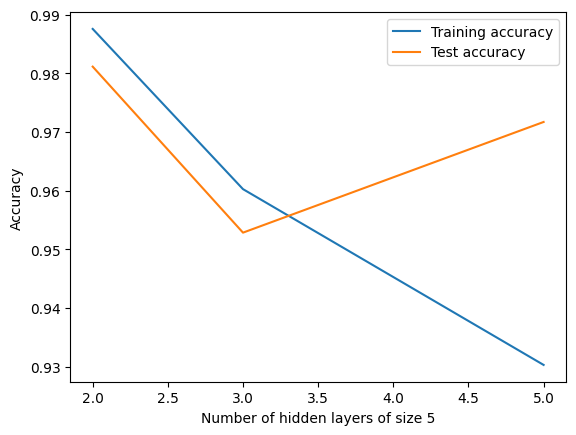

In [35]:
hidden_layers = [2, 3, 5]
accuracy_train = []
accuracy_test = []


for l in hidden_layers:
    nn = MLPClassifier(
        hidden_layer_sizes=(5,) * l,
        solver="sgd",
        random_state=RANDOM_SEED,
        learning_rate_init=LEARNING_RATE,
    )

    accuracy_val = cross_val_score(estimator=nn, X=X_BoW_train, y=y_train, cv=NUM_FOLDS)
    accuracy_train.append(sum(accuracy_val) / NUM_FOLDS)

    nn.fit(X_BoW_train, y_train)
    accuracy_test.append(nn.score(X_BoW_test, y_test))


plt.plot(hidden_layers, accuracy_train, label="Training accuracy")
plt.plot(hidden_layers, accuracy_test, label="Test accuracy")

plt.xlabel("Number of hidden layers of size 5")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

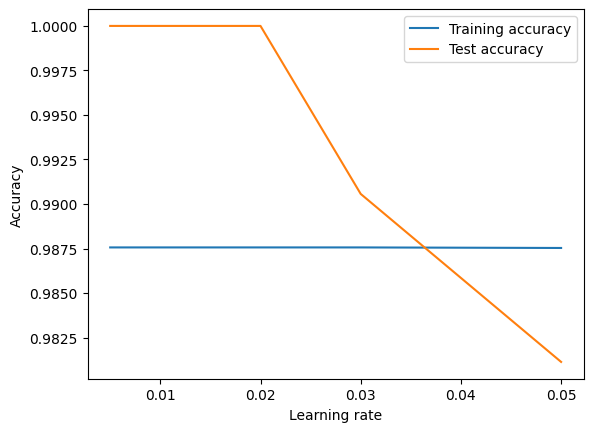

In [36]:
learning_rates = [0.005, 0.02, 0.03, 0.05]
accuracy_train = []
accuracy_test = []


for lr in learning_rates:
    nn = MLPClassifier(
        hidden_layer_sizes=(5, 5),
        solver="sgd",
        random_state=RANDOM_SEED,
        learning_rate_init=lr,
    )

    accuracy_val = cross_val_score(estimator=nn, X=X_BoW_train, y=y_train, cv=NUM_FOLDS)
    accuracy_train.append(sum(accuracy_val) / NUM_FOLDS)

    nn.fit(X_BoW_train, y_train)
    accuracy_test.append(nn.score(X_BoW_test, y_test))


plt.plot(learning_rates, accuracy_train, label="Training accuracy")
plt.plot(learning_rates, accuracy_test, label="Test accuracy")

plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.legend()

plt.show()